필요한 모듈 불러오기

In [1]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

sqlite DB에서 데이터 불러오기

In [2]:
con = sqlite3.connect(r"C:\Users\구남이\OneDrive\바탕 화면\활동들\한이음 멘토링\stock.db")
df = pd.read_sql("SELECT * FROM '039490'", con, index_col=None)
df.rename(columns={'index':'date'}, inplace=True)
df = df.set_index('date')
df

,open,high,low,close,volume
date,,,,,
20220517,85000,87600,85000,87600,55677
20220516,86900,87600,85700,85900,55383
20220513,84000,87400,83500,85800,86525
20220512,84700,85300,82700,83200,104007
20220511,87500,87500,85500,85800,108071
...,...,...,...,...,...
20040429,5117,5436,5025,5101,109911
20040428,5071,5452,4995,5444,182604
20040427,5452,5482,5033,5063,299489


In [3]:
df.index = pd.DatetimeIndex(df.index)
df.index

DatetimeIndex(['2022-05-17', '2022-05-16', '2022-05-13', '2022-05-12',
               '2022-05-11', '2022-05-10', '2022-05-09', '2022-05-06',
               '2022-05-04', '2022-05-03',
               ...
               '2004-05-07', '2004-05-06', '2004-05-04', '2004-05-03',
               '2004-04-30', '2004-04-29', '2004-04-28', '2004-04-27',
               '2004-04-26', '2004-04-23'],
              dtype='datetime64[ns]', name='date', length=4471, freq=None)

데이터 정렬

In [4]:
df.sort_index(ascending=True, inplace=True)
df

,open,high,low,close,volume
date,,,,,
2004-04-23,6076,6799,5353,5353,1415109
2004-04-26,5436,5741,5261,5398,343283
2004-04-27,5452,5482,5033,5063,299489
2004-04-28,5071,5452,4995,5444,182604
2004-04-29,5117,5436,5025,5101,109911
...,...,...,...,...,...
2022-05-11,87500,87500,85500,85800,108071
2022-05-12,84700,85300,82700,83200,104007
2022-05-13,84000,87400,83500,85800,86525


데이터 시각화

Text(0, 0.5, 'price')

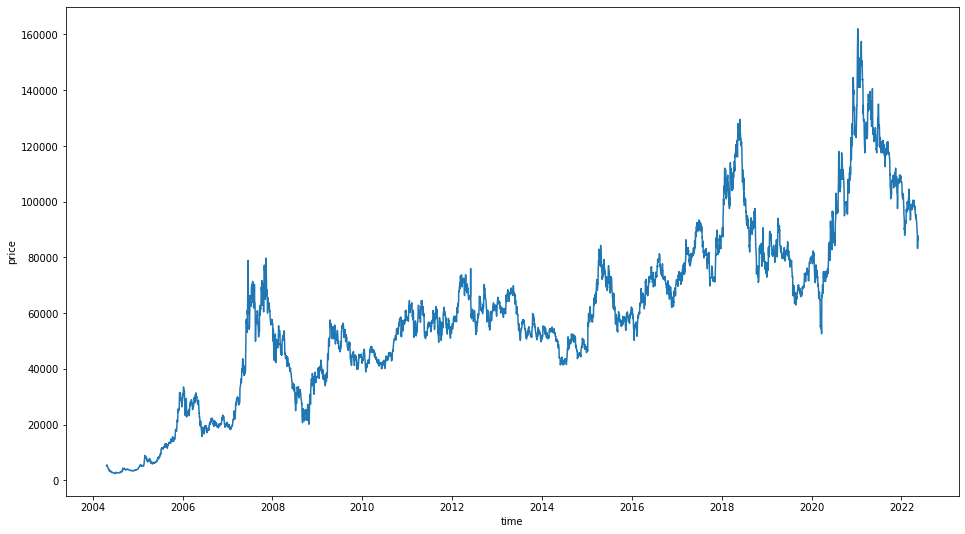

In [5]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=df['close'], x=df.index)
plt.xlabel('time')
plt.ylabel('price')

데이터 스케일링

In [6]:
from sklearn.preprocessing import MinMaxScaler

# 피처값 스케일링
scaler = MinMaxScaler()
df[['open','high','low','volume']] = scaler.fit_transform(df[['open','high','low','volume']])

# 타켓 스케일링
scaler1 = MinMaxScaler()
df['close'] = scaler1.fit_transform(df['close'].values.reshape(-1,1))

# 스케일링 결과 확인
df


,open,high,low,close,volume
date,,,,,
2004-04-23,0.022741,0.026226,0.019066,0.018324,1.000000
2004-04-26,0.018743,0.019815,0.018467,0.018606,0.241077
2004-04-27,0.018842,0.018245,0.016982,0.016507,0.210068
2004-04-28,0.016462,0.018063,0.016734,0.018894,0.127305
2004-04-29,0.016750,0.017967,0.016930,0.016745,0.075834
...,...,...,...,...,...
2022-05-11,0.531437,0.515237,0.540941,0.522470,0.074531
2022-05-12,0.513944,0.501906,0.522709,0.506176,0.071653
2022-05-13,0.509571,0.514631,0.527918,0.522470,0.059275


train, test 분할 (20%가 test 데이터)

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)
print('train set 확인: ' ,  x_train.shape, y_train.shape)
print('test set 확인: ' ,  x_test.shape, y_test.shape)

train set 확인:  (3576, 4) (3576,)
test set 확인:  (895, 4) (895,)


C:\Users\구남이\AppData\Local\Temp\ipykernel_1168\1519034930.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('close', 1), df['close'], test_size=0.2, random_state=11, shuffle=False)


In [8]:
y_test

date
2018-10-01    0.580124
2018-10-02    0.541897
2018-10-04    0.514323
2018-10-05    0.506176
2018-10-08    0.498656
                ...   
2022-05-11    0.522470
2022-05-12    0.506176
2022-05-13    0.522470
2022-05-16    0.523096
2022-05-17    0.533750
Name: close, Length: 895, dtype: float64

TensroFlow Dataset을 이용한 시퀀스 데이터 구성

In [9]:
import tensorflow as tf
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

하이퍼 파라미터 정의

In [10]:
WINDOW_SIZE=20
BATCH_SIZE=32

trian_data는 학습용 데이터셋, test_data는 검증용 데이터셋

In [11]:
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

데이터셋의 구성을 확인

In [12]:
# X: (batch_size, window_size, feature)
# Y: (batch_size, feature)
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 20, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


모델링

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])


 Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용

In [14]:
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

earlystopping은 10번 epoch통안 val_loss 개선이 없다면 학습을 멈춘다.

In [15]:
earlystopping = EarlyStopping(monitor='val_loss', patience=10)

val_loss 기준 체크포인터도 생성

In [16]:
import os
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=50, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/50
112/112 [==============================] - 12s 38ms/step - loss: 0.0024 - mse: 0.0047 - val_loss: 7.2028e-04 - val_mse: 0.0014

Epoch 00001: val_loss improved from inf to 0.00072, saving model to tmp\ckeckpointer.ckpt
Epoch 2/50
112/112 [==============================] - 3s 24ms/step - loss: 2.3600e-04 - mse: 4.7201e-04 - val_loss: 8.7574e-04 - val_mse: 0.0018

Epoch 00002: val_loss did not improve from 0.00072
Epoch 3/50
112/112 [==============================] - 3s 24ms/step - loss: 1.9843e-04 - mse: 3.9687e-04 - val_loss: 6.3223e-04 - val_mse: 0.0013

Epoch 00003: val_loss improved from 0.00072 to 0.00063, saving model to tmp\ckeckpointer.ckpt
Epoch 4/50
112/112 [==============================] - 3s 24ms/step - loss: 1.9106e-04 - mse: 3.8212e-04 - val_loss: 6.2344e-04 - val_mse: 0.0012

Epoch 00004: val_loss improved from 0.00063 to 0.00062, saving model to tmp\ckeckpointer.ckpt
Epoch 5/50
112/112 [==============================] - 3s 24ms/step - loss: 1.7874e-04 - mse: 3

저장한 ModelCheckpoint 를 로드

In [17]:
model.load_weights(filename)

test_data를 활용하여 예측

In [18]:
pred = model.predict(test_data)
pred.shape

(875, 1)

In [19]:
pred

array([[0.4382904 ],
       [0.45166725],
       [0.46161824],
       [0.48535407],
       [0.504729  ],
       [0.51012003],
       [0.50952595],
       [0.5088218 ],
       [0.51046777],
       [0.51292276],
       [0.51095414],
       [0.5034717 ],
       [0.49995753],
       [0.5036531 ],
       [0.51313704],
       [0.5116942 ],
       [0.49854505],
       [0.48759988],
       [0.47528207],
       [0.47622603],
       [0.48363286],
       [0.49075842],
       [0.5047644 ],
       [0.51580495],
       [0.5374568 ],
       [0.5423553 ],
       [0.53067803],
       [0.50512874],
       [0.48876897],
       [0.48129123],
       [0.47865143],
       [0.4859972 ],
       [0.49329698],
       [0.4908844 ],
       [0.48172325],
       [0.46990073],
       [0.46999013],
       [0.46721038],
       [0.4652974 ],
       [0.4623699 ],
       [0.4566725 ],
       [0.46016908],
       [0.46846408],
       [0.4664302 ],
       [0.4549669 ],
       [0.44875926],
       [0.457457  ],
       [0.466

예측 데이터(스케일링) 시각화

In [20]:
print(pred.shape)
print(y_test.shape) # test data set의 앞의 20개 데이터로 21번째 데이터를 예측하기 때문

(875, 1)
(895,)


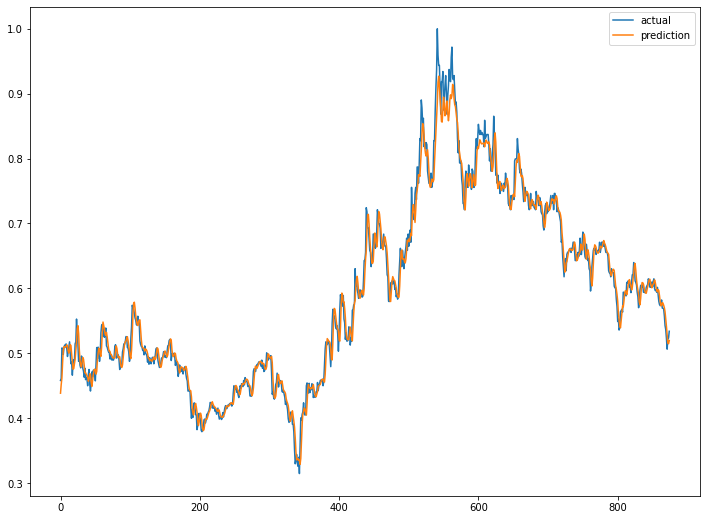

In [21]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[20:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

스케일링 전 값으로 역변환

In [22]:
rescaled_y_test = scaler1.inverse_transform(np.array(y_test).reshape(-1, 1))
rescaled_pred = scaler1.inverse_transform(np.array(pred).reshape(-1,1))

rescaled_y_test 

array([[ 95000.],
       [ 88900.],
       [ 84500.],
       [ 83200.],
       [ 82000.],
       [ 79000.],
       [ 74000.],
       [ 75900.],
       [ 74700.],
       [ 75300.],
       [ 76600.],
       [ 76600.],
       [ 76900.],
       [ 76900.],
       [ 73000.],
       [ 74400.],
       [ 71000.],
       [ 71100.],
       [ 71400.],
       [ 74000.],
       [ 75500.],
       [ 76000.],
       [ 83500.],
       [ 83400.],
       [ 81900.],
       [ 83600.],
       [ 84200.],
       [ 83800.],
       [ 84500.],
       [ 83400.],
       [ 81400.],
       [ 82500.],
       [ 83800.],
       [ 85000.],
       [ 82000.],
       [ 79600.],
       [ 80000.],
       [ 76800.],
       [ 79600.],
       [ 80600.],
       [ 80500.],
       [ 84500.],
       [ 85000.],
       [ 90600.],
       [ 86800.],
       [ 84400.],
       [ 80200.],
       [ 81000.],
       [ 79200.],
       [ 78600.],
       [ 81500.],
       [ 81200.],
       [ 78500.],
       [ 77800.],
       [ 76300.],
       [ 7

In [23]:
rescaled_pred = scaler1.inverse_transform(np.array(pred).reshape(-1,1))
rescaled_pred

array([[ 72367.44 ],
       [ 74501.99 ],
       [ 76089.88 ],
       [ 79877.44 ],
       [ 82969.11 ],
       [ 83829.37 ],
       [ 83734.57 ],
       [ 83622.2  ],
       [ 83884.85 ],
       [ 84276.6  ],
       [ 83962.46 ],
       [ 82768.48 ],
       [ 82207.72 ],
       [ 82797.43 ],
       [ 84310.79 ],
       [ 84080.555],
       [ 81982.336],
       [ 80235.8  ],
       [ 78270.234],
       [ 78420.87 ],
       [ 79602.78 ],
       [ 80739.81 ],
       [ 82974.76 ],
       [ 84736.516],
       [ 88191.52 ],
       [ 88973.18 ],
       [ 87109.83 ],
       [ 83032.9  ],
       [ 80422.35 ],
       [ 79229.125],
       [ 78807.89 ],
       [ 79980.06 ],
       [ 81144.89 ],
       [ 80759.91 ],
       [ 79298.06 ],
       [ 77411.53 ],
       [ 77425.8  ],
       [ 76982.23 ],
       [ 76676.98 ],
       [ 76209.83 ],
       [ 75300.69 ],
       [ 75858.64 ],
       [ 77182.28 ],
       [ 76857.734],
       [ 75028.52 ],
       [ 74037.97 ],
       [ 75425.875],
       [ 7681

MSE 계산

In [24]:
MSE = np.square(np.subtract((rescaled_y_test)[20:], rescaled_pred)).mean()
MSE

9037608.66498584

RMSE 계산

In [25]:
import math
rmse = math.sqrt(MSE)
rmse

3006.2615762747323

시각화

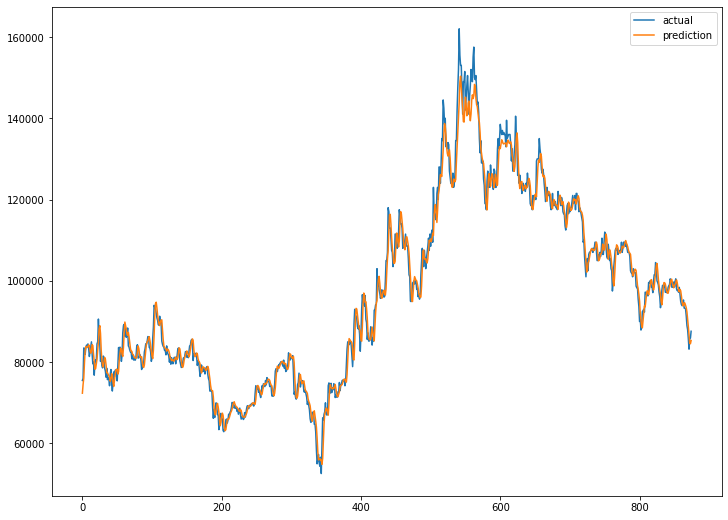

In [26]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(rescaled_y_test)[20:], label='actual')
plt.plot(rescaled_pred, label='prediction')
plt.legend()
plt.show()